## Prediction Model for the given variables

### Import the requisite modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import time

#### Set the variable on which we need to perform predictions here

Transactions was chosen as the default target variable for the model

In [10]:
VAR = 'Trans'

### Feature Engineering

Load the given data into a Pandas dataframe

In [3]:
df_orig = pd.read_csv('topline_metrics.csv')
del df_orig['Date.1']

In [3]:
df_orig.head()

,Date,Platform,Country,TRU,DAU,Items,Trans,Items Per Trans,Items per DAU,Conversion,Cash Flow,Return Customer,Time Spend Per Day(seconds)
0,2018-03-15,Android(All),Kazakhstan(哈萨克斯坦),628852.81,15498.31,43429.11,3428.09,17.58,1.3,2.3,4527.01,79.12,58.18
1,2018-03-15,ALL,United States(美国),633293.54,19939.05,43429.11,3428.09,17.58,1.3,2.3,4527.01,75.65,58.87
2,2018-03-15,Android(All),Kazakhstan(哈萨克斯坦),628852.81,15498.31,43429.11,3428.09,17.58,1.3,2.3,4527.01,79.12,58.18
3,2018-03-15,ALL,Guatemala(危地马拉),628976.03,15621.54,43429.11,3428.09,17.58,1.3,2.3,4527.01,74.62,46.21
4,2018-03-15,Android(All),Belarus(白俄罗斯),629154.54,15800.04,43429.11,3428.09,17.58,1.3,2.3,4527.01,76.97,56.92


Create a Copy of the Dataframe for making predictions. Also the data contains numerous entries for the same country, Date, and Platform i.e. duplicates, which are also removed in this step

In [4]:
df = df_orig.copy()
df.drop_duplicates(subset = ["Date",'Platform','Country'],keep=False, inplace = True)

The Country codes need to be ASCI compatible, for input to our models. Hence the Country names are trimmed/renamed so that they contain only English characters

In [5]:
chinese_map = {}
global_cnt = 0

In [6]:
def trim(s):
    idx = s.find('(')
    if(idx >= 0):
        ns = s[0:idx]
        ns = ns.strip()
        if(ns == 'Côte dIvoire'):
            return 'Cote dIvoire'
        return ns
    else:
        if(s in chinese_map.keys()):
            return chinese_map[s]
        else:
            ns = 'chinese_name_'+str(trim.counter)
            chinese_map[s] = ns
            trim.counter += 1
            return ns
trim.counter = 0

Creating other useful features from the given date information. Also it was observed that the Time spent field had negative entries, which doesnt make sense. Hence, these negative entries were made zero, to ensure consistency.

In [7]:
df['Country'] = df['Country'].apply(lambda x: trim(x))
df['Date'] =  pd.to_datetime(df['Date'])
df['dayofmonth'] = df.Date.dt.day
df['dayofyear'] = df.Date.dt.dayofyear
df['dayofweek'] = df.Date.dt.dayofweek
df['month'] = df.Date.dt.month
df['year'] = df.Date.dt.year
df['weekofyear'] = df.Date.dt.weekofyear
df['is_month_start'] = (df.Date.dt.is_month_start).astype(int)
df['is_month_end'] = (df.Date.dt.is_month_end).astype(int)
df['weekend'] = ((df.Date.dt.dayofweek) // 5 == 1).astype(int)
df.loc[df['Time Spend Per Day(seconds)'] < 0,'Time Spend Per Day(seconds)'] = 0

In [8]:
df.head()

,Date,Platform,Country,TRU,DAU,Items,Trans,Items Per Trans,Items per DAU,Conversion,...,Time Spend Per Day(seconds),dayofmonth,dayofyear,dayofweek,month,year,weekofyear,is_month_start,is_month_end,weekend
5,2018-03-15,Android(All),Ghana,628648.96,15294.47,43429.11,3428.09,17.58,1.3,2.3,...,101.95,15,74,3,3,2018,11,0,0,0
19,2018-03-15,ALL,Moldova,628748.01,15393.51,43429.11,3428.09,17.58,1.3,2.3,...,62.79,15,74,3,3,2018,11,0,0,0
20,2018-03-15,ALL,Costa Rica,629171.81,15817.32,43429.11,3428.09,17.58,1.3,2.3,...,48.16,15,74,3,3,2018,11,0,0,0
21,2018-03-15,ALL,Algeria,628847.05,15492.55,43429.11,3428.09,17.58,1.3,2.3,...,50.81,15,74,3,3,2018,11,0,0,0
28,2018-03-15,Android(All),Australia,628712.31,15357.81,43429.11,3428.09,17.58,1.3,2.3,...,36.88,15,74,3,3,2018,11,0,0,0


Sorting values, in order of Country, Platform, and Date

In [9]:
df.sort_values(by=['Country','Platform','Date'], axis=0, inplace=True)
df.reset_index(drop=True,inplace=True)

Converting the prediction variable to log scale to address variance and scale issues

In [11]:
PREDICT_VAR = VAR + '_log'
df[PREDICT_VAR] = np.log1p(df[VAR].values)

Plotting the Prediction variable in log scale vs Days to get a sense of the data. In the below example, we are just looking at USA for 'ALL' platforms.

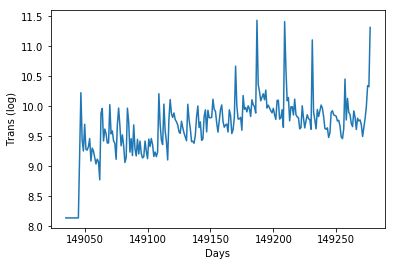

In [18]:
temp_log = df[(df['Country'] == 'United States') & (df['Platform'] == 'ALL')][PREDICT_VAR]
plt.plot(temp_log)
plt.xlabel('Days')
plt.ylabel('Trans (log)')
plt.show()

### Creating a Model for the prediction variable

Creating a copy of the dataframe for modelling

In [21]:
df_new = df.copy()

In [22]:
def create_agg_monthwise_features(df, gpby_cols, target_col, agg_funcs):
    
    gpby = df.groupby(gpby_cols)
    newdf = df[gpby_cols].drop_duplicates().reset_index(drop=True)
    for agg_name, agg_func in agg_funcs.items():
        aggdf = gpby[target_col].agg(agg_func).reset_index()
        aggdf.rename(columns={target_col:target_col+'_'+agg_name}, inplace=True)
        newdf = newdf.merge(aggdf, on=gpby_cols, how='left')
    return newdf

The future value of a time series variable, depends on its past. Hence we construct new features that reflect this hypothesis.

#### 1) Lag features: 

Take features, that lag the prediction variable, by a specified lag amount

#### 2) Rolling Mean features: 

Take a rolling average on the prediction variable, over a specified window length. Rolling mean, smooths out our variable, but causes the prection variable to lag behind, on account of average over its predecessors. These features assume that instead of depending on its history, the current value of the prediction variable, depends only on the previous values in the window.

#### 3) Rolling Median features: 

Similar to Rolling Mean, but the calculate the median to ensure robustness to outliers.

#### 4) Exponentially Weighted features: 

Similar to Rolling Mean, with a few essential modifications. The values in the window were given equal weight in calculating rolling mean features. But here, their weights are exponentially decaying, with the most recent variables in the window, given higher weight that the distant variables in the window. Also, using exponential weighting ameliorates the issue with lag, which is prominent when we use rolling mean.

In [23]:
# Creating lag features
def create_lag_features(df, gpby_cols, target_col, lags):
    gpby = df.groupby(gpby_cols)
    for i in lags:
        df['_'.join([target_col, 'lag', str(i)])] = \
                gpby[target_col].shift(i).values + np.random.normal(scale=1.6, size=(len(df),))
    return df

# Creating rolling mean features
def create_rmean_features(df, gpby_cols, target_col, windows, min_periods=2, 
                             shift=1, win_type=None):
    gpby = df.groupby(gpby_cols)
    for w in windows:
        df['_'.join([target_col, 'rmean', str(w)])] = \
            gpby[target_col].shift(shift).rolling(window=w, 
                                                  min_periods=min_periods,
                                                  win_type=win_type).mean().values +\
            np.random.normal(scale=1.6, size=(len(df),))
    return df

# Creating rolling median features
def create_rmed_features(df, gpby_cols, target_col, windows, min_periods=2, 
                            shift=1, win_type=None):
    gpby = df.groupby(gpby_cols)
    for w in windows:
        df['_'.join([target_col, 'rmed', str(w)])] = \
            gpby[target_col].shift(shift).rolling(window=w, 
                                                  min_periods=min_periods,
                                                  win_type=win_type).median().values +\
            np.random.normal(scale=1.6, size=(len(df),))
    return df

# Creating exponentially weighted mean features
def create_ewm_features(df, gpby_cols, target_col, alpha=[0.9], shift=[1]):
    gpby = df.groupby(gpby_cols)
    for a in alpha:
        for s in shift:
            df['_'.join([target_col, 'lag', str(s), 'ewm', str(a)])] = \
                gpby[target_col].shift(s).ewm(alpha=a).mean().values
    return df

Convert the Categorical variables in our dataframe, such as Country, Platform, and Date Features ( weekend, month, year etc.). This is a prerequisite for modelling, when we have categorical variables in our data.

In [24]:
def one_hot_encoder(df, ohe_cols=['Country','Platform','dayofmonth','dayofweek','month','weekofyear']):
    
    df = pd.get_dummies(df, columns=ohe_cols)
    print('Final df shape:{}'.format(df.shape))
    return df

We need to carefully chose lags and window lengths, while handcrafting features. For lag, we have chose variables that are spaced by a distance of seven, in order to take into consideration, weekly seasonality, if any. Also, lags of 364 and 728, were chosen to reflect yearly seasonality, if any. 69 was chosen as the start, since our test data, is split so that it contains the dates in the year 2020 (which are 69 in number).

In [27]:
df_new = create_lag_features(df_new, gpby_cols=['Country','Platform'], target_col=PREDICT_VAR, 
                               lags=[69,76,83,91,98,105,112,119,126,182,364,546,728])

df_new = create_rmean_features(df_new, gpby_cols=['Country','Platform'], 
                                 target_col=PREDICT_VAR, windows=[364,546], 
                                 min_periods=10, win_type='triang')

df_new = create_ewm_features(df_new, gpby_cols=['Country','Platform'], 
                               target_col=PREDICT_VAR, 
                               alpha=[0.95, 0.9, 0.8, 0.7, 0.6, 0.5], 
                               shift=[69,76,83,91,98,105,112,119,126,182,364,546,728])

df_new = one_hot_encoder(df_new, ohe_cols=['Country','Platform','dayofweek','month'])

Final df shape:(166542, 371)


Split the data into train and validation, for the purpose of testing the performance of our model. The val data contains entries that correspond to dates in the year 2020.

In [28]:
train = df_new[df_new['year'] < 2020]
train.reset_index(drop = True, inplace = True)
Y_train = train[PREDICT_VAR].values.reshape((-1))

In [29]:
train.head()

,Date,TRU,DAU,Items,Trans,Items Per Trans,Items per DAU,Conversion,Cash Flow,Return Customer,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2018-03-17,628666.24,15301.38,43429.11,3428.09,17.58,1.3,2.3,4527.01,41.00,...,1,0,0,0,0,0,0,0,0,0
1,2018-03-18,628670.85,15301.38,43429.11,3428.09,17.58,1.3,2.3,4527.01,55.39,...,1,0,0,0,0,0,0,0,0,0
2,2018-03-21,629205.21,15694.09,43429.11,3428.09,17.58,1.3,2.3,4527.01,56.43,...,1,0,0,0,0,0,0,0,0,0
3,2018-03-24,629594.46,15569.71,43429.11,3428.09,17.58,1.3,2.3,4527.01,53.78,...,1,0,0,0,0,0,0,0,0,0
4,2018-03-30,629657.80,15423.45,43429.11,3428.09,17.58,1.3,2.3,4527.01,54.63,...,1,0,0,0,0,0,0,0,0,0


In [30]:
val = df_new[df_new['year'] == 2020]
val.reset_index(drop = True, inplace = True)
Y_val = val[PREDICT_VAR].values.reshape((-1))

In [31]:
val.head()

,Date,TRU,DAU,Items,Trans,Items Per Trans,Items per DAU,Conversion,Cash Flow,Return Customer,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2020-01-02,703783.37,16655.71,47555.45,3699.88,35.06,1.35,2.71,4831.05,55.98,...,0,0,0,0,0,0,0,0,0,0
1,2020-01-03,705077.81,16704.08,47340.09,3625.02,40.45,1.35,2.60,4683.64,53.25,...,0,0,0,0,0,0,0,0,0,0
2,2020-01-05,703927.32,16576.25,46301.31,3676.85,30.88,1.34,2.68,4705.52,52.18,...,0,0,0,0,0,0,0,0,0,0
3,2020-01-08,704634.43,16675.29,47321.66,3714.85,33.20,1.35,2.74,4728.55,49.22,...,0,0,0,0,0,0,0,0,0,0
4,2020-01-09,705417.55,16806.58,50927.46,3968.21,33.56,1.41,3.10,4690.55,51.18,...,0,0,0,0,0,0,0,0,0,0


In [32]:
agg_df = create_agg_monthwise_features(df,gpby_cols=['Country','Platform','month'],target_col=PREDICT_VAR, 
                                       agg_funcs={'mean':np.mean, 'median':np.median, 'max':np.max, 'min':np.min,
                                                  'std':np.std})

In [33]:
agg_df.head()

,Country,Platform,month,Trans_log_mean,Trans_log_median,Trans_log_max,Trans_log_min,Trans_log_std
0,Afghanistan,ALL,3,8.164740,8.148745,8.315770,8.140050,0.048036
1,Afghanistan,ALL,4,8.151036,8.154057,8.169178,8.140050,0.008832
2,Afghanistan,ALL,5,8.155029,8.152234,8.175680,8.141729,0.012201
3,Afghanistan,ALL,6,8.154532,8.156372,8.170480,8.140386,0.011107
4,Afghanistan,ALL,7,8.153969,8.143070,8.206946,8.141059,0.018436


Specify Columns the model need to avoid considering. That includes columns, Date, Year, and our prediction variables; that only need to be a part of the target array.

In [34]:
avoid_cols = ['Date', PREDICT_VAR, VAR, 'year']
cols = [col for col in train.columns if col not in avoid_cols]
print('No of training features: {} \nAnd they are:{}'.format(len(cols), cols))

No of training features: 367 
And they are:['TRU', 'DAU', 'Items', 'Items Per Trans', 'Items per DAU', 'Conversion', 'Cash Flow', 'Return Customer', 'Time Spend Per Day(seconds)', 'dayofmonth', 'dayofyear', 'weekofyear', 'is_month_start', 'is_month_end', 'weekend', 'Trans_log_lag_69', 'Trans_log_lag_76', 'Trans_log_lag_83', 'Trans_log_lag_91', 'Trans_log_lag_98', 'Trans_log_lag_105', 'Trans_log_lag_112', 'Trans_log_lag_119', 'Trans_log_lag_126', 'Trans_log_lag_182', 'Trans_log_lag_364', 'Trans_log_lag_546', 'Trans_log_lag_728', 'Trans_log_rmean_364', 'Trans_log_rmean_546', 'Trans_log_lag_69_ewm_0.95', 'Trans_log_lag_76_ewm_0.95', 'Trans_log_lag_83_ewm_0.95', 'Trans_log_lag_91_ewm_0.95', 'Trans_log_lag_98_ewm_0.95', 'Trans_log_lag_105_ewm_0.95', 'Trans_log_lag_112_ewm_0.95', 'Trans_log_lag_119_ewm_0.95', 'Trans_log_lag_126_ewm_0.95', 'Trans_log_lag_182_ewm_0.95', 'Trans_log_lag_364_ewm_0.95', 'Trans_log_lag_546_ewm_0.95', 'Trans_log_lag_728_ewm_0.95', 'Trans_log_lag_69_ewm_0.9', 'Trans_

We intend to build a Light Gradient Boosted Model (Light GBM), that uses a Gradient Boosted Learning framework, for Decision Trees, and is quite quick. We use Symmentric Mean Absolute Prediction Error (SMAPE), that is commonly used when working with Times series data.

$SMAPE = \frac{200}{n} \sum_{i=1}^{n} \frac{|F_t - A_t|}{|F_t| + |A_t|}$

Where $F_t$ is the forecasted point, and $A_t$ is the Actual point. Here, $n$ corresponds to the number of fitted points. Below, we define functions to calculate the SMAPE for the Light GBM model.

In [35]:
def SMAPE(preds, target):

    n = len(preds)
    masked_arr = ~((preds==0)&(target==0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def LGBM_SMAPE(preds, train_data):

    labels = train_data.get_label()
    smape_val = SMAPE(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [36]:
lgb_params = {'task':'train', 'boosting_type':'gbdt', 'objective':'regression', 
              'metric': {'mae'}, 'num_leaves': 10, 'learning_rate': 0.02, 
              'feature_fraction': 0.8, 'max_depth': 5, 'verbose': 0, 
              'num_boost_round':15000, 'early_stopping_rounds':200, 'nthread':-1}

In [37]:
lgbtrain = lgb.Dataset(data=train.loc[:,cols].values, label=Y_train, 
                       feature_name=cols)
lgbval = lgb.Dataset(data=val.loc[:,cols].values, label=Y_val, 
                     reference=lgbtrain, feature_name=cols)

In [40]:
def lgb_validation(params, lgbtrain, lgbval, X_val, Y_val, verbose_eval):
    t0 = time.time()
    evals_result = {}
    model = lgb.train(params, lgbtrain, num_boost_round=params['num_boost_round'], 
                      valid_sets=[lgbtrain, lgbval], feval=LGBM_SMAPE, 
                      early_stopping_rounds=params['early_stopping_rounds'], 
                      evals_result=evals_result, verbose_eval=verbose_eval)
    print(model.best_iteration)
    print('Total time taken to build the model: ', (time.time()-t0)/60, 'minutes!!')
    pred_Y_val = model.predict(X_val, num_iteration=model.best_iteration)
    pred_Y_val = np.expm1(pred_Y_val)
    Y_val = np.expm1(Y_val)
    val_df = pd.DataFrame(columns=['true_Y_val','pred_Y_val'])
    val_df['pred_Y_val'] = pred_Y_val
    val_df['true_Y_val'] = Y_val
    print(val_df.shape)
    print(val_df.sample(5))
    print('SMAPE for validation data is:{}'.format(SMAPE(pred_Y_val, Y_val)))
    return model, val_df

In [41]:
model, val_df = lgb_validation(lgb_params, lgbtrain, lgbval, val.loc[:,cols].values, 
                               Y_val, verbose_eval=500)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[500]	training's l1: 0.00326635	training's SMAPE: 0.32656	valid_1's l1: 0.00646918	valid_1's SMAPE: 0.642565
[1000]	training's l1: 0.00253432	training's SMAPE: 0.253434	valid_1's l1: 0.00552973	valid_1's SMAPE: 0.549984
[1500]	training's l1: 0.00226585	training's SMAPE: 0.226602	valid_1's l1: 0.00523743	valid_1's SMAPE: 0.520918
[2000]	training's l1: 0.00206754	training's SMAPE: 0.206778	valid_1's l1: 0.00501338	valid_1's SMAPE: 0.49868
[2500]	training's l1: 0.0019039	training's SMAPE: 0.190415	valid_1's l1: 0.00482741	valid_1's SMAPE: 0.48019
[3000]	training's l1: 0.00177984	training's SMAPE: 0.17801	valid_1's l1: 0.00470862	valid_1's SMAPE: 0.468365
[3500]	training's l1: 0.00167211	training's SMAPE: 0.167237	valid_1's l1: 0.00459741	valid_1's SMAPE: 0.457283
[4000]	training's l1: 0.00158973	training's SMAPE: 0.158999	valid_1's l1: 0.00451897	valid_1's SMAPE: 0.449472
[4500]	training's l1: 0.00152099	training's SMAPE: 0.152

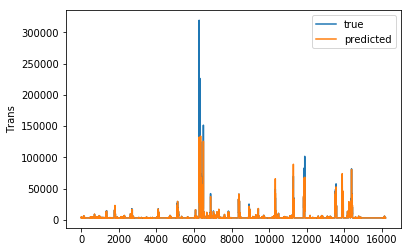

In [49]:
plt.plot(val_df['true_Y_val'], label = 'true')
plt.plot(val_df['pred_Y_val'], label = 'predicted')
plt.legend(loc = 'best')
plt.ylabel(VAR)
plt.show()

We see that the model is able to correctly predict the treds in the validation data, across all countries, platforms, and dates. Now, we look at one country, 'United States' and compare the performance of our model, against the true validation values.

In [47]:
val_timeframe = df[(df['year'] == 2020)].reset_index()
del val_timeframe['index']

In [48]:
val_timeframe.head()

,Date,Platform,Country,TRU,DAU,Items,Trans,Items Per Trans,Items per DAU,Conversion,...,dayofmonth,dayofyear,dayofweek,month,year,weekofyear,is_month_start,is_month_end,weekend,Trans_log
0,2020-01-02,ALL,Afghanistan,703783.37,16655.71,47555.45,3699.88,35.06,1.35,2.71,...,2,2,3,1,2020,1,0,0,0,8.216326
1,2020-01-03,ALL,Afghanistan,705077.81,16704.08,47340.09,3625.02,40.45,1.35,2.60,...,3,3,4,1,2020,1,0,0,0,8.195891
2,2020-01-05,ALL,Afghanistan,703927.32,16576.25,46301.31,3676.85,30.88,1.34,2.68,...,5,5,6,1,2020,1,0,0,1,8.210084
3,2020-01-08,ALL,Afghanistan,704634.43,16675.29,47321.66,3714.85,33.20,1.35,2.74,...,8,8,2,1,2020,2,0,0,0,8.220363
4,2020-01-09,ALL,Afghanistan,705417.55,16806.58,50927.46,3968.21,33.56,1.41,3.10,...,9,9,3,1,2020,2,0,0,0,8.286322


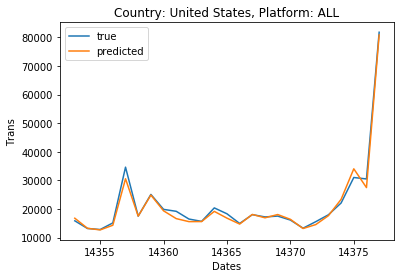

In [53]:
idx = val_timeframe[(val_timeframe['Country'] == 'United States') & (val_timeframe['Platform'] == 'ALL')]['Trans'].index
plt.plot(val_df.loc[idx,'true_Y_val'], label = 'true')
plt.plot(val_df.loc[idx,'pred_Y_val'], label = 'predicted')
plt.xlabel('Dates')
plt.ylabel(VAR)
plt.title('Country: United States, Platform: ALL')
plt.legend(loc = 'best')
plt.show()

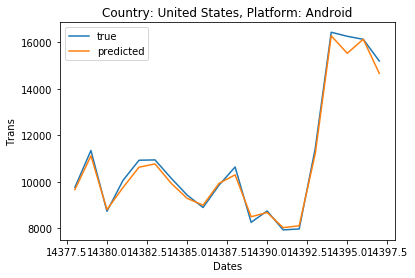

In [57]:
idx = val_timeframe[(val_timeframe['Country'] == 'United States') & (val_timeframe['Platform'] == 'Android(All)')]\
['Trans'].index
plt.plot(val_df.loc[idx,'true_Y_val'], label = 'true')
plt.plot(val_df.loc[idx,'pred_Y_val'], label = 'predicted')
plt.xlabel('Dates')
plt.ylabel(VAR)
plt.title('Country: United States, Platform: Android')
plt.legend(loc = 'best')
plt.show()

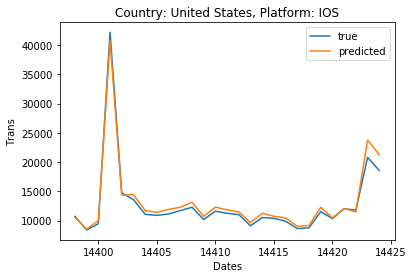

In [56]:
idx = val_timeframe[(val_timeframe['Country'] == 'United States') & (val_timeframe['Platform'] == 'IOS(All)')]\
['Trans'].index
plt.plot(val_df.loc[idx,'true_Y_val'], label = 'true')
plt.plot(val_df.loc[idx,'pred_Y_val'], label = 'predicted')
plt.xlabel('Dates')
plt.ylabel(VAR)
plt.title('Country: United States, Platform: IOS')
plt.legend(loc = 'best')
plt.show()

The Low SMAPE score of 0.389, and the plots, prove that our model is well trained, and is able to successfully predict the values of the target variables.

### Feature Importance

Looking at the top 10 features, that are most important in predicting the target variable, we observe that

In [65]:
print("Features importance...")
gain = model.feature_importance('gain')
feat_imp = pd.DataFrame({'feature':model.feature_name(), 
                         'split':model.feature_importance('split'), 
                         'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
print('Top 10 features:\n', feat_imp.head(10))

Features importance...
Top 10 features:
                      feature  split       gain
2                      Items  15341  71.589069
0                        TRU   8911  11.586365
3            Items_Per_Trans  13016   7.089127
6                  Cash_Flow   8045   6.919396
5                 Conversion   9794   2.135389
95  Trans_log_lag_69_ewm_0.5    796   0.165567
1                        DAU   4598   0.160236
82  Trans_log_lag_69_ewm_0.6    505   0.116744
4              Items_per_DAU   3120   0.062458
16          Trans_log_lag_76   2942   0.040694


We see that, the initially provided features are the most important in predicting the target variable. It is suprising that the lag features, are not really important in making predictions. After looking at the data, we see that the data is not exactly seasonal, and is mostly characterized by the trend of initial growth, followed by a plateau. So, it makes sense that the initially provided features are more important in capturing the behaviour of the prediction variable.

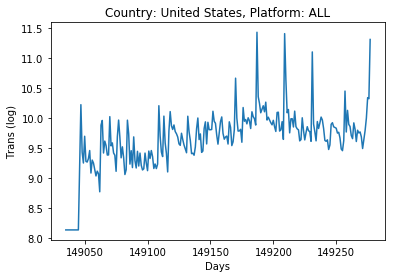

In [63]:
temp_log = df[(df['Country'] == 'United States') & (df['Platform'] == 'ALL')][PREDICT_VAR]
plt.plot(temp_log)
plt.xlabel('Days')
plt.ylabel('Trans (log)')
plt.title('Country: United States, Platform: ALL')
plt.show()

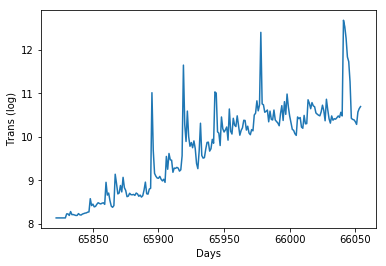

In [60]:
temp_log = df[(df['Country'] == 'India') & (df['Platform'] == 'ALL')][PREDICT_VAR]
plt.plot(temp_log)
plt.xlabel('Days')
plt.ylabel('Trans (log)')
plt.title('Country: India, Platform: ALL')
plt.show()

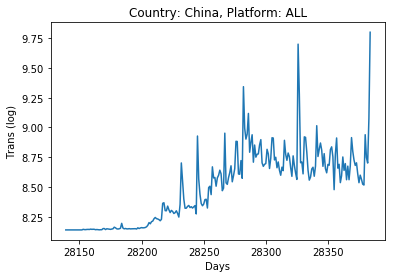

In [64]:
temp_log = df[(df['Country'] == 'China') & (df['Platform'] == 'ALL')][PREDICT_VAR]
plt.plot(temp_log)
plt.xlabel('Days')
plt.ylabel('Trans (log)')
plt.title('Country: China, Platform: ALL')
plt.show()